In [1]:
import os

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from shorelineforecasting.utils.configs import GluonConfigs

basepath = "/media/storage/data/shorelines/"

tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [2]:
sites = pd.read_pickle("/media/storage/data/shorelines/sites-gluonts-prepared.pkl")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
sites['coastline_idint'] = sites['coastline_idint'].astype(int)

In [3]:
from sklearn.cluster import DBSCAN

kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian

db = DBSCAN(eps=epsilon,
            min_samples=1,
            algorithm='ball_tree', 
            metric='haversine'
           ).fit(np.radians(sites[['Intersect_lat','Intersect_lon']]))


sites['dbscan_cluster'] = db.labels_
print(f"Number of cluters: {len(sites['dbscan_cluster'].unique())}")

Number of cluters: 13311


In [57]:
from sklearn.cluster import OPTICS

# op = OPTICS(eps=epsilon,
#             max_eps=2,
#             min_samples=2,
#             cluster_method='dbscan',
#             algorithm='ball_tree',
#             metric='haversine'
#            ).fit(np.radians(sites[['Intersect_lat', 'Intersect_lon']]))



op = OPTICS(
    eps=epsilon,
    min_samples=2,
    max_eps=2,
    xi =0.05, 
).fit(np.radians(sites[['Intersect_lat', 'Intersect_lon']]))

sites['optics_clusters'] = op.labels_

In [58]:
len(sites['optics_clusters'].unique())

10373

In [29]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

Z = ward(pdist(sites[['Intersect_lat', 'Intersect_lon']].values))
sites['fcluster'] = fcluster(Z, t=0.05, criterion='distance')

In [30]:
folium_colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

In [31]:
sum(sites['fcluster'].value_counts()==1)

1243

In [62]:
import folium 

target = 'dbscan_cluster'

random_choice = np.random.choice(sites[target].unique(), size=1000)
sample = sites.loc[sites[target].isin(random_choice)]
start_coords = sample.iloc[0][['Intersect_lat', 'Intersect_lon']].values

m = folium.Map(location=start_coords, zoom_start=4)
for gr, frame in sample.groupby(target):
    color=np.random.choice(folium_colors)
    fill_color=np.random.choice(folium_colors)
    for row in frame.iterrows():
        folium.CircleMarker(
            location=[row[1]['geometry'].y, row[1]['geometry'].x],
            color=color,
            fill_color=fill_color
        ).add_to(m)

In [63]:
m

In [88]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def canopy(X, T1, T2, distance_metric='haversine', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

canopy(sample[['Intersect_lon', 'Intersect_lat']].values, 1, 1)

{0: {'c': 0,
  'points': [0,
   1,
   2,
   3,
   4,
   5,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   142,
   143,
   144,
   145,
   146,
   147,
   148,
   149,
   150,
   151,
   152,
   153,
   154,
   155,
   156,
   157,
   158,
   159,
   160,
   161,
   162,
   163,
   164,
   165,
   166,
   167,
   168,
   169,
   170,
   171,
   172,
   173,
   174,
   175,
   176,
   177,
   178,
   179,
   180,
   181,
   182,
   183,
   184,
   185,
   186,
 

In [77]:
grouped = sample.groupby('cluster')

roi = make_geodataframe(grouped.get_group(3))
m = interactive_geospatial_plot(roi)
m

In [63]:
import folium
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

def make_geodataframe(df: pd.DataFrame) -> gpd.GeoDataFrame:
    crs = CRS("epsg:4326")
    geometries = gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat)
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometries)

def plot_spatial_distribution(gdf: gpd.GeoDataFrame) -> None:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    world.plot(ax=ax, alpha=.4)
    gdf.plot(markersize=2, ax=ax, label=f"Transects (n={len(gdf)})")
    
    ax.set_xlabel('Longitude [$^\circ$]')
    ax.set_ylabel('Latitude [$^\circ$]')
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

def interactive_geospatial_plot(gdf):
    start_coords = gdf.iloc[0][['Intersect_lon', 'Intersect_lat']].values
    m = folium.Map(location=start_coords, zoom_start=4)
    
    folium.Choropleth(
        geo_data=gdf
    ).add_to(m)
    

    return m

roi = make_geodataframe(sample)

m = interactive_geospatial_plot(roi)


In [40]:
values = np.arange(5, 10, 1)
colors = cm.LinearColormap(colors=['red', 'lightblue'], vmin=min(sample['cluster']), vmax=max(sample['cluster']))

In [45]:
colors(3)

'#f61819ff'

In [48]:
max(sample['cluster'])

35

In [53]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(sample['cluster']), vmax=max(sample['cluster']))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

(-1.0, 35.0)


In [57]:
scalarMap.to_rgba(3)

(0.0, 0.0, 0.999108734402852, 1.0)

In [58]:
import folium.plugins

import branca
import branca.colormap as cm


x_start = (sample['Intersect_lon'].max() + sample['Intersect_lat'].min()) / 2
y_start = (sample['Intersect_lon'].max() + sample['Intersect_lat'].min()) / 2
start_coord = (x_start, y_start)

colormap = cm.LinearColormap(colors=['red', 'lightblue'], vmin=min(sample['cluster']), vmax=max(sample['cluster']))

m = folium.Map(location=start_coord, zoom_start=12)


lat = list(sample.Intersect_lat)
lon = list(sample.Intersect_lon)
cluster = list(sample.cluster)


for loc, c in zip(zip(lat, lon), cluster):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=scalarMap.to_rgba(c),
        #fill_opacity=0.7
    ).add_to(m)
    
m

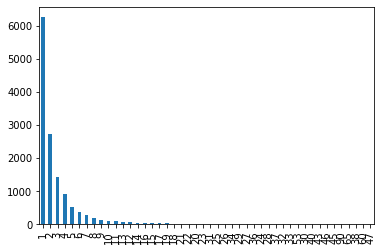

In [14]:

sites['cluster'].value_counts().value_counts().plot(kind='bar')

In [26]:
m

In [ ]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

points = np.array([[33.    , 41.    ],
       [33.9693, 41.3923],
       [33.6074, 41.277 ],
       [34.4823, 41.919 ],
       [34.3702, 41.1424],
       [34.3931, 41.078 ],
       [34.2377, 41.0576],
       [34.2395, 41.0211],
       [34.4443, 41.3499],
       [34.3812, 40.9793]])


def distance(origin, destination): #found here https://gist.github.com/rochacbruno/2883505
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def create_clusters(number_of_clusters,points):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(points)
    l_array = np.array([[label] for label in kmeans.labels_])
    clusters = np.append(points,l_array,axis=1)
    return clusters

def validate_solution(max_dist,clusters):
    _, __, n_clust = clusters.max(axis=0)
    n_clust = int(n_clust)
    for i in range(n_clust):
        two_d_cluster=clusters[clusters[:,2] == i][:,np.array([True, True, False])]
        if not validate_cluster(max_dist,two_d_cluster):
            return False
        else:
            continue
    return True

def validate_cluster(max_dist,cluster):
    distances = cdist(cluster,cluster, lambda ori,des: int(round(distance(ori,des))))
    print(distances)
    print(30*'-')
    for item in distances.flatten():
        if item > max_dist:
            return False
    return True

if __name__ == '__main__':
    for i in range(2,len(points)):
        print(i)
        print(validate_solution(20,create_clusters(i,points)))

2
[[ 0. 75. 50. 55. 43. 46. 53. 60.]
 [75.  0. 72. 78. 84. 87. 52. 87.]
 [50. 72.  0.  6. 17. 18. 21. 15.]
 [55. 78.  6.  0. 17. 18. 26.  9.]
 [43. 84. 17. 17.  0.  3. 35. 18.]
 [46. 87. 18. 18.  3.  0. 38. 16.]
 [53. 52. 21. 26. 35. 38.  0. 35.]
 [60. 87. 15.  9. 18. 16. 35.  0.]]
------------------------------
False
3
[[0.]]
------------------------------
[[ 0. 50. 55. 43. 46. 53. 60.]
 [50.  0.  6. 17. 18. 21. 15.]
 [55.  6.  0. 17. 18. 26.  9.]
 [43. 17. 17.  0.  3. 35. 18.]
 [46. 18. 18.  3.  0. 38. 16.]
 [53. 21. 26. 35. 38.  0. 35.]
 [60. 15.  9. 18. 16. 35.  0.]]
------------------------------
False
4
[[0.]]
------------------------------
[[ 0.  6. 17. 18. 21. 15.]
 [ 6.  0. 17. 18. 26.  9.]
 [17. 17.  0.  3. 35. 18.]
 [18. 18.  3.  0. 38. 16.]
 [21. 26. 35. 38.  0. 35.]
 [15.  9. 18. 16. 35.  0.]]
------------------------------
False
5
[[0.]]
------------------------------
[[ 0.  6. 17. 18. 21. 15.]
 [ 6.  0. 17. 18. 26.  9.]
 [17. 17.  0.  3. 35. 18.]
 [18. 18.  3.  0. 38. 16

In [2]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle 

ModuleNotFoundError: No module named 'geopy'